In [185]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree

In [186]:
# Dataset is from Kaggle
# https://www.kaggle.com/c/titanic/overview

#from google.colab import files
#uploaded = files.upload()

import io
titanic_data = pd.read_csv(io.BytesIO(uploaded['Titanic.csv']))

In [170]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [187]:
# Exploratory analysis
# Evaluate target variable distribution

titanic_data.Survived.mean()

0.3838383838383838

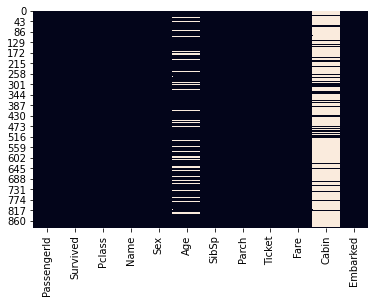

In [188]:
# Explore missing values

sns.heatmap(titanic_data.isnull(), cbar=False)

In [189]:
titanic_data_clean = titanic_data.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)

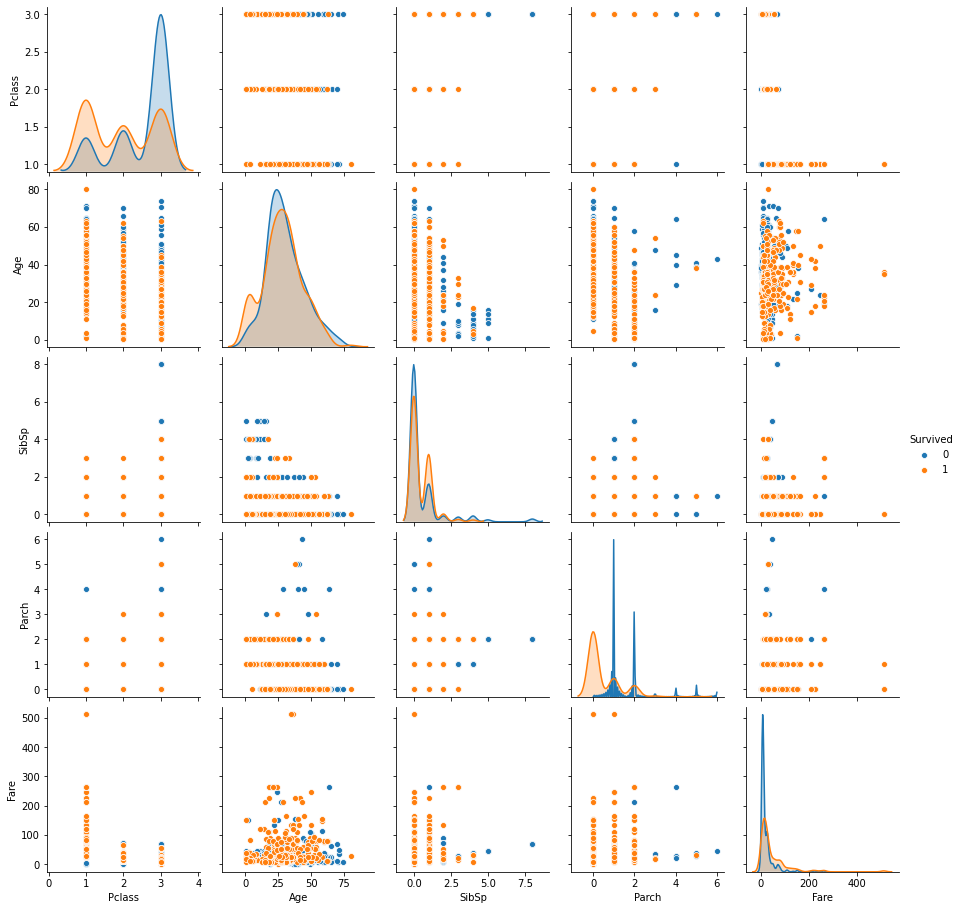

In [190]:
sns.pairplot(titanic_data_clean, hue = 'Survived')

In [191]:
titanic_data_clean.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [194]:
titanic_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    int64   
 1   Pclass    891 non-null    category
 2   Sex       891 non-null    object  
 3   Age       714 non-null    float64 
 4   SibSp     891 non-null    int64   
 5   Parch     891 non-null    int64   
 6   Fare      891 non-null    float64 
 7   Embarked  889 non-null    object  
dtypes: category(1), float64(2), int64(3), object(2)
memory usage: 49.8+ KB


In [193]:
 titanic_data_clean['Pclass'] =  titanic_data_clean['Pclass'].astype('category',copy=False)

In [201]:
# tree.DecisionTreeClassifier() does not support missing values
# Mean imputation would bias the model
# I will replace missing values with 999 to distinguish records with missing values

titanic_data_clean['Age'].fillna(999, inplace=True)



In [202]:
# Decision trees are not affected by multicollinearity
# Need to keep all dummy variables

titanic_data_clean = pd.get_dummies(titanic_data_clean)

In [196]:
titanic_data_clean.describe()

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
count,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594,32.204208,0.242424,0.206510,0.551066,0.352413,0.647587,0.188552,0.086420,0.722783
std,0.486592,14.526497,1.102743,0.806057,49.693429,0.428790,0.405028,0.497665,0.477990,0.477990,0.391372,0.281141,0.447876
min,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,38.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [203]:
X = titanic_data_clean.drop('Survived', axis=1)
y = titanic_data_clean['Survived']

In [198]:
X.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [205]:
dt_model = tree.DecisionTreeClassifier(min_samples_leaf=5, max_depth=3)

dt_model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [207]:
y_pred = dt_model.predict(X_test)

In [208]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(y_test,y_pred)

array([[141,  12],
       [ 49,  66]])

In [209]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.92      0.82       153
           1       0.85      0.57      0.68       115

    accuracy                           0.77       268
   macro avg       0.79      0.75      0.75       268
weighted avg       0.79      0.77      0.76       268



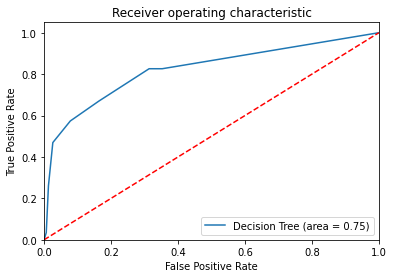

In [210]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

dt_roc_auc = roc_auc_score(y_test, dt_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dt_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % dt_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

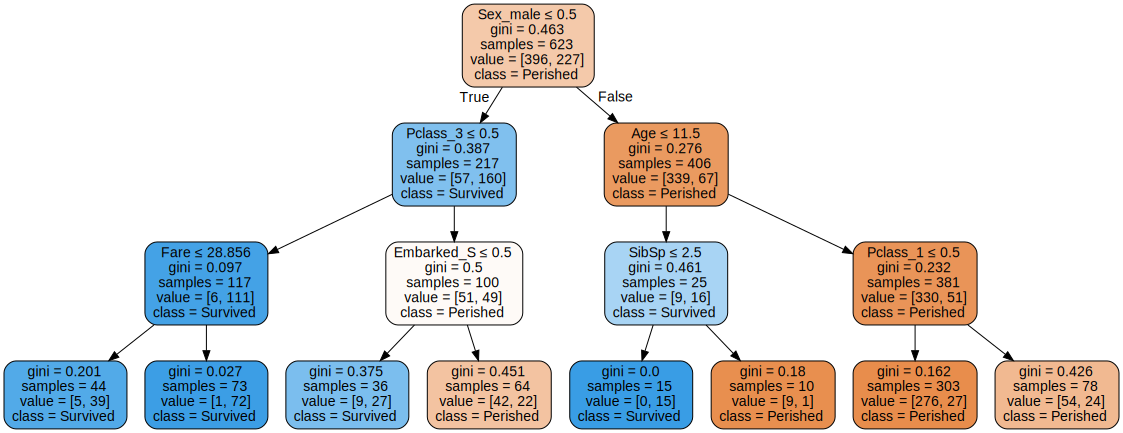

In [ ]:
import graphviz 
dot_data = tree.export_graphviz(dt_model, out_file=None, 
                      feature_names=X.columns,  
                      class_names=['Perished','Survived'],
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 


In [212]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

rf_model  = RandomForestClassifier(max_depth=5, random_state=0)
rf_model.fit(X_train,y_train)

y_pred_rf = rf_model.predict(X_test)

confusion_matrix(y_test,y_pred_rf)

array([[141,  12],
       [ 48,  67]])

In [213]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.75      0.92      0.82       153
           1       0.85      0.58      0.69       115

    accuracy                           0.78       268
   macro avg       0.80      0.75      0.76       268
weighted avg       0.79      0.78      0.77       268



In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

print(classification_report(y_test, rf_random.predict(X_test)))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.5min finished


              precision    recall  f1-score   support

           0       0.76      0.92      0.83       153
           1       0.85      0.61      0.71       115

    accuracy                           0.79       268
   macro avg       0.81      0.77      0.77       268
weighted avg       0.80      0.79      0.78       268



In [214]:
# Boosted tree model

from sklearn.ensemble import AdaBoostClassifier

bt_model = AdaBoostClassifier(n_estimators=100)

bt_model.fit(X_train,y_train)

y_pred_bt = bt_model.predict(X_test)

confusion_matrix(y_test,y_pred_bt)

array([[131,  22],
       [ 42,  73]])

In [215]:
print(classification_report(y_test,y_pred_bt))

              precision    recall  f1-score   support

           0       0.76      0.86      0.80       153
           1       0.77      0.63      0.70       115

    accuracy                           0.76       268
   macro avg       0.76      0.75      0.75       268
weighted avg       0.76      0.76      0.76       268



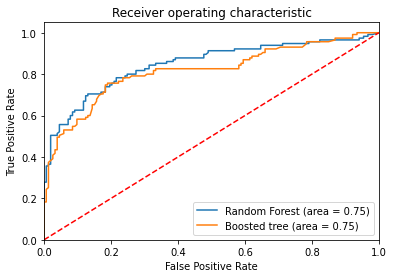

In [216]:
# Random Forest 
rf_roc_auc = roc_auc_score(y_test, rf_model.predict(X_test))
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])

# Boosted Tree
bt_roc_auc = roc_auc_score(y_test, bt_model.predict(X_test))
bt_fpr, bt_tpr, bt_thresholds = roc_curve(y_test, bt_model.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(bt_fpr, bt_tpr, label='Boosted tree (area = %0.2f)' % bt_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()